In [1]:
import numpy as np
import pandas as pd
import yaml
import torch
import matplotlib.pyplot as plt

from torch import nn
import scanpy as sc

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.vdm.denoising_model import SimpleMLPTimeStep
from celldreamer.models.vdm.vdm import VDM
from celldreamer.eval.optimal_transport import wasserstein

from celldreamer.models.base.utils import unsqueeze_right

device  = "cuda" if torch.cuda.is_available() else "cpu"

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


**Util function**

In [2]:
def init_feature_embeddings(dataset, dataset_config, device):
    feature_embeddings = {}  
    num_classes = {}
            
    for cov, cov_names in dataset.id2cov.items():
        feature_embeddings["y_"+cov] = CategoricalFeaturizer(len(cov_names), 
                                                                  dataset_config["one_hot_encode_features"], 
                                                                  device, 
                                                                  embedding_dimensions=dataset_config["cov_embedding_dimensions"])
        if dataset_config["one_hot_encode_features"]:
            num_classes["y_"+cov] = len(cov_names)
        else:
            num_classes["y_"+cov] = dataset_config["cov_embedding_dimensions"]
    return feature_embeddings

**Cofigurations**

In [3]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/celldreamer_trained/f841f70b-2b9a-471b-a47f-42cdd47d2064/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]

In [4]:
dataset_config = {'dataset_path': '../../datasets/processed/dentategyrus.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['clusters'],
                    'sampling_covariate': 'clusters',
                    'subsample_frac': 1,
                    'encoder_type': 'learnt',
                    'target_max': 1,
                    'target_min': -1,
                    'n_dimensions': None,
                    'one_hot_encode_features': True,
                    'split_rates': [0.90, 0.05, 0.05],
                    'cov_embedding_dimensions': None}

generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'noise_schedule': 'learnt_linear',
                            'gamma_min': -4.,
                            'gamma_max': 4.,
                            'antithetic_time_sampling': False,
                            'scaling_method': 'log_normalization',
                            'x0_from_x_kwargs': {
                                'dims': [512, 512],
                                'batch_norm': False,
                                'dropout': False,
                                'dropout_p': 0.0
                            },
                            'pretrain_encoder': True,
                            'pretraining_encoder_epochs': 150,
                            'use_tanh_encoder': False}

**Initialization**

Initialize dataset 

In [5]:
data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                                layer_key=dataset_config["layer_key"],
                                covariate_keys=dataset_config["covariate_keys"],
                                subsample_frac=dataset_config["subsample_frac"], 
                                encoder_type=dataset_config["encoder_type"],
                                target_max=dataset_config["target_max"], 
                                target_min=dataset_config["target_min"])

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


Initialize feature embeddings

In [6]:
feature_embeddings = init_feature_embeddings(dataset, dataset_config, device)

Initialize VDM 

In [7]:
generative_model = VDM(
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=in_dim,
            size_factor_statistics=size_factor_statistics,
            scaler=None,
            encoder_type=dataset_config["encoder_type"],
            sampling_covariate=dataset_config["sampling_covariate"],
            model_type=denoising_model.model_type, 
            **generative_model_config  # model_kwargs should contain the rest of the arguments
        )

generative_model.load_state_dict(ckpt["state_dict"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


<All keys matched successfully>

**Check the data**

In [8]:
adata_original = sc.read_h5ad(data_path)
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)

In [9]:
X = torch.tensor(adata_original.layers["X_counts"].todense())

In [10]:
# wasserstein(X_1, X_2)

More or less the range for the Wasserstein distance must be 100-200

**Collect checkpoints and run**

In [11]:
z, X_generated = generative_model.sample(batch_size=1000, 
                                     n_sample_steps=100, 
                                     clip_samples=False,
                                     covariate="clusters")

sampling:   1%|          | 1/100 [00:00<00:15,  6.23it/s]

tensor(-4.9481)
tensor(-5.3767)
tensor(-5.1778)


sampling:   5%|▌         | 5/100 [00:00<00:08, 11.83it/s]

tensor(-5.0693)
tensor(-5.0453)
tensor(-5.0786)
tensor(-5.1548)


sampling:   9%|▉         | 9/100 [00:00<00:06, 13.41it/s]

tensor(-5.2501)
tensor(-5.2469)
tensor(-5.3641)
tensor(-5.4520)


sampling:  13%|█▎        | 13/100 [00:01<00:06, 14.08it/s]

tensor(-5.5167)
tensor(-5.6140)
tensor(-5.8250)
tensor(-5.8786)


sampling:  17%|█▋        | 17/100 [00:01<00:05, 14.26it/s]

tensor(-5.8979)
tensor(-5.8876)
tensor(-5.5348)
tensor(-5.5962)


sampling:  21%|██        | 21/100 [00:01<00:05, 14.39it/s]

tensor(-5.6562)
tensor(-5.6352)
tensor(-5.6589)
tensor(-5.6738)


sampling:  25%|██▌       | 25/100 [00:01<00:05, 14.67it/s]

tensor(-5.6044)
tensor(-5.9382)
tensor(-5.7019)
tensor(-5.7742)


sampling:  29%|██▉       | 29/100 [00:02<00:04, 15.90it/s]

tensor(-5.9547)
tensor(-5.8687)
tensor(-6.0084)
tensor(-6.1989)


sampling:  34%|███▍      | 34/100 [00:02<00:03, 17.99it/s]

tensor(-6.2903)
tensor(-6.4899)
tensor(-6.6512)
tensor(-6.7591)
tensor(-6.7201)


sampling:  40%|████      | 40/100 [00:02<00:03, 19.62it/s]

tensor(-6.7565)
tensor(-6.6611)
tensor(-6.4578)
tensor(-6.6094)
tensor(-6.6540)


sampling:  45%|████▌     | 45/100 [00:02<00:02, 19.71it/s]

tensor(-6.6426)
tensor(-6.8237)
tensor(-6.7793)
tensor(-6.9468)


sampling:  47%|████▋     | 47/100 [00:02<00:02, 19.54it/s]

tensor(-6.9925)
tensor(-7.0196)
tensor(-7.0598)
tensor(-7.1715)
tensor(-7.2438)


sampling:  53%|█████▎    | 53/100 [00:03<00:02, 20.45it/s]

tensor(-7.4409)
tensor(-7.6130)
tensor(-7.5337)
tensor(-7.4103)
tensor(-7.5348)


sampling:  59%|█████▉    | 59/100 [00:03<00:01, 21.60it/s]

tensor(-7.6611)
tensor(-7.6967)
tensor(-7.8869)
tensor(-7.9632)
tensor(-8.1032)


sampling:  62%|██████▏   | 62/100 [00:03<00:01, 21.94it/s]

tensor(-8.1344)
tensor(-8.3005)
tensor(-8.3458)
tensor(-8.4617)
tensor(-8.3623)


sampling:  68%|██████▊   | 68/100 [00:03<00:01, 22.33it/s]

tensor(-8.1831)
tensor(-8.2411)
tensor(-8.3765)
tensor(-8.4594)
tensor(-8.5467)


sampling:  74%|███████▍  | 74/100 [00:04<00:01, 22.47it/s]

tensor(-8.6710)
tensor(-8.8220)
tensor(-8.7483)
tensor(-8.3917)
tensor(-8.4123)


sampling:  77%|███████▋  | 77/100 [00:04<00:01, 22.49it/s]

tensor(-8.2839)
tensor(-8.3697)
tensor(-8.3855)
tensor(-8.6087)
tensor(-8.5466)


sampling:  83%|████████▎ | 83/100 [00:04<00:00, 22.60it/s]

tensor(-8.5554)
tensor(-8.4179)
tensor(-8.6907)
tensor(-8.7599)
tensor(-8.7045)


sampling:  89%|████████▉ | 89/100 [00:04<00:00, 22.73it/s]

tensor(-8.6155)
tensor(-8.5864)
tensor(-8.7531)
tensor(-8.8645)
tensor(-8.7467)


sampling:  92%|█████████▏| 92/100 [00:04<00:00, 22.66it/s]

tensor(-8.8181)
tensor(-8.9127)
tensor(-8.7715)
tensor(-8.7645)
tensor(-8.6913)


sampling:  98%|█████████▊| 98/100 [00:05<00:00, 22.59it/s]

tensor(-8.6531)
tensor(-8.7913)
tensor(-8.6419)
tensor(-8.6456)
tensor(-8.6846)


sampling: 100%|██████████| 100/100 [00:05<00:00, 18.82it/s]


In [12]:
z.max()

tensor(13.7531)

In [13]:
adata_original.X.A.max(1)

array([4.2341065, 4.1743875, 5.598422 , ..., 3.6635616, 3.4965076,
       2.6390574], dtype=float32)

Analyze the results

Create adata and check plots

In [14]:
adata = sc.AnnData(X=X_generated.cpu().numpy())

In [15]:
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [16]:
adata.obs["size_factor"] = adata.X.sum(1)

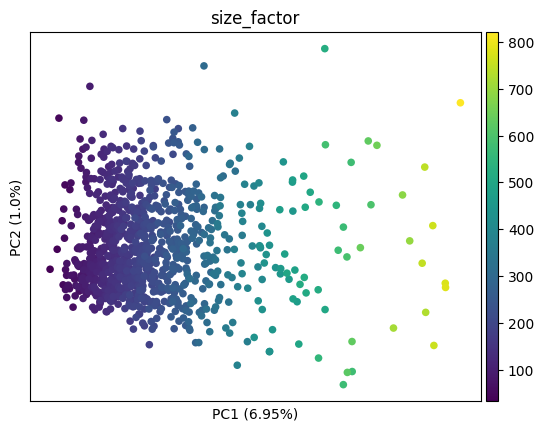

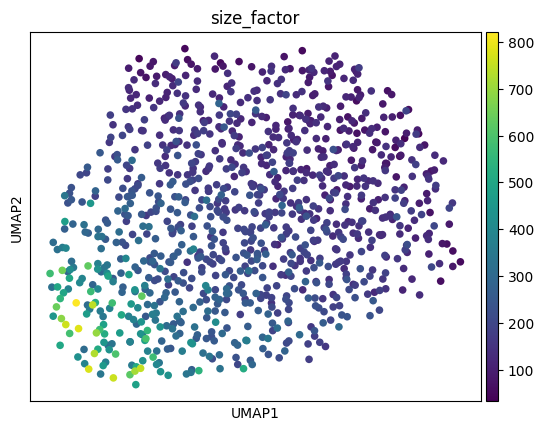

In [17]:
sc.pl.pca(adata, color="size_factor", annotate_var_explained=True)
sc.pl.umap(adata, color="size_factor")

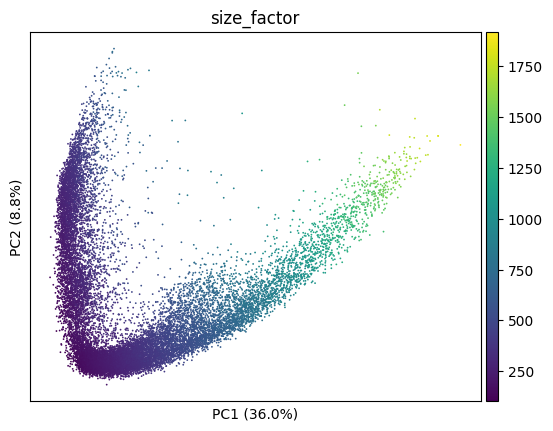

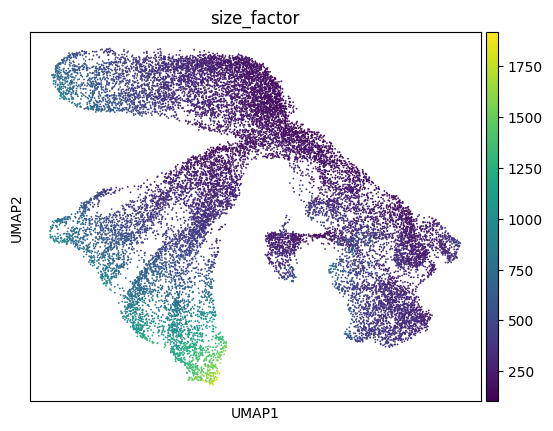

In [18]:
sc.pl.pca(adata_original, color="size_factor",  annotate_var_explained=True)
sc.pl.umap(adata_original, color="size_factor")

In [19]:
adata_original.X.sum(1).max()

1919.949

In [20]:
adata.X.sum(1).max()

821.1454

Theta is very high 

In [21]:
for i in generative_model.theta:
    print(i)

tensor(6.5989, grad_fn=<UnbindBackward0>)
tensor(6.5939, grad_fn=<UnbindBackward0>)
tensor(6.9869, grad_fn=<UnbindBackward0>)
tensor(7.1301, grad_fn=<UnbindBackward0>)
tensor(7.6293, grad_fn=<UnbindBackward0>)
tensor(7.5930, grad_fn=<UnbindBackward0>)
tensor(1.9761, grad_fn=<UnbindBackward0>)
tensor(7.0673, grad_fn=<UnbindBackward0>)
tensor(7.4056, grad_fn=<UnbindBackward0>)
tensor(7.0704, grad_fn=<UnbindBackward0>)
tensor(7.8410, grad_fn=<UnbindBackward0>)
tensor(6.9902, grad_fn=<UnbindBackward0>)
tensor(7.1314, grad_fn=<UnbindBackward0>)
tensor(6.9879, grad_fn=<UnbindBackward0>)
tensor(6.5907, grad_fn=<UnbindBackward0>)
tensor(8.0086, grad_fn=<UnbindBackward0>)
tensor(7.9840, grad_fn=<UnbindBackward0>)
tensor(6.9886, grad_fn=<UnbindBackward0>)
tensor(6.5314, grad_fn=<UnbindBackward0>)
tensor(4.8306, grad_fn=<UnbindBackward0>)
tensor(3.8705, grad_fn=<UnbindBackward0>)
tensor(7.0690, grad_fn=<UnbindBackward0>)
tensor(7.0697, grad_fn=<UnbindBackward0>)
tensor(6.9876, grad_fn=<UnbindBack

(array([ 12.,  54., 167., 206., 314., 447., 463., 267.,  63.,   7.]),
 array([-15.54821777, -12.97918797, -10.41015816,  -7.84112835,
         -5.27209854,  -2.70306873,  -0.13403893,   2.43499088,
          5.00402069,   7.5730505 ,  10.14208031]),
 <BarContainer object of 10 artists>)

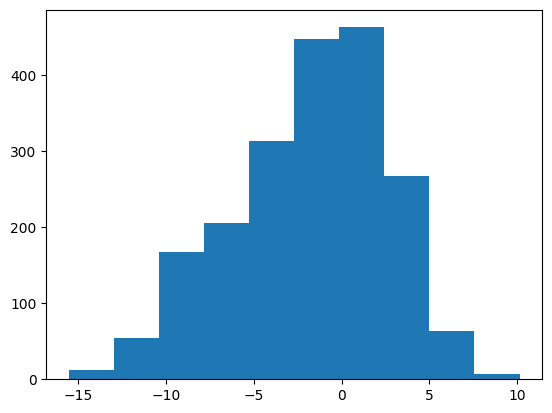

In [22]:
plt.hist(z[0])

In [23]:
for i in z[0]:
    print(i)

tensor(-10.4447)
tensor(-2.8934)
tensor(-6.7554)
tensor(1.4895)
tensor(2.4536)
tensor(-0.3573)
tensor(-9.9242)
tensor(-5.7128)
tensor(1.4622)
tensor(-3.8980)
tensor(1.5685)
tensor(-0.2773)
tensor(2.7754)
tensor(3.0745)
tensor(-7.9272)
tensor(2.8536)
tensor(0.1816)
tensor(-0.9131)
tensor(-2.6988)
tensor(-1.2400)
tensor(1.4930)
tensor(-0.7325)
tensor(0.1809)
tensor(2.5570)
tensor(3.6010)
tensor(-6.3972)
tensor(0.4234)
tensor(3.1499)
tensor(0.1029)
tensor(4.2984)
tensor(-3.6797)
tensor(0.4244)
tensor(-1.0904)
tensor(3.7930)
tensor(-2.2543)
tensor(-0.3190)
tensor(-2.2546)
tensor(0.3828)
tensor(-8.2285)
tensor(-2.1900)
tensor(-1.0062)
tensor(-5.7374)
tensor(0.1794)
tensor(4.1135)
tensor(-9.3884)
tensor(-0.3110)
tensor(-3.3261)
tensor(2.8274)
tensor(0.2834)
tensor(-2.8372)
tensor(2.2428)
tensor(-0.0075)
tensor(-3.3671)
tensor(1.8215)
tensor(-3.6781)
tensor(-2.0890)
tensor(3.1039)
tensor(-0.7744)
tensor(-4.0913)
tensor(-14.5633)
tensor(-3.6017)
tensor(1.2574)
tensor(-13.1836)
tensor(-1.2259)
